<a href="https://colab.research.google.com/github/annis/desgw-cos/blob/master/Resp_to_micropore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's follow the classic thinking in "Micropore: Python, fit with error on both axes"

https://micropore.wordpress.com/2017/02/07/python-fit-with-error-on-both-axis/


In [412]:
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
from scipy import odr
import seaborn as sns



In [413]:
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
# Set tensor numeric type.
dtype = 'float32'

#from importlib import reload
#reload(tf)

In [362]:
def gen_func(p, x):
  a, b, c, d = p
  return a*x**3 + b*x**2 + c*x**1 + d*x**0

def func(p, x):
  a, b, c = p
  return a*x**2 + b*x**1 + c*x**0 


In [363]:
# test data and error
x0 = np.linspace(-10, 10, 100)
y0= gen_func([0.006, -0.07, 0.5, 2], x0)
#y0 = (0.006*x0**3) + (-0.07 * x0**2) + (0.5 * x0) + 2.
noise_x = np.random.normal(0.0, 1.0, len(x0))
noise_y = np.random.normal(0.0, 1.0, len(x0))
y = y0 + noise_y
x = x0 + noise_x

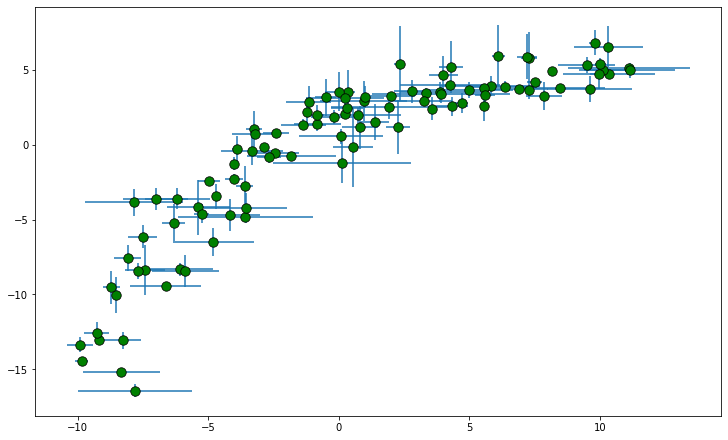

In [364]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), constrained_layout=True)
plt.errorbar(x,y,xerr=noise_x,yerr=noise_y, ls="none",zorder=1)
sns.scatterplot(x=x,y=y, s=90, color="g", edgecolor="k",zorder=10)

In [414]:
# Model object
quad_model = odr.Model(func)
# Create a RealData object
data = odr.RealData(x, y, sx=noise_x, sy=noise_y)

# Set up ODR with the model and data.
todr = odr.ODR(data, quad_model, beta0=[0., 1., 1.])

# Run the regression.
out = todr.run()

In [395]:
#print fit parameters and 1-sigma estimates
popt = out.beta
perr = out.sd_beta

params =  ["a*x**2", "b*x",  "c"]

print("fit parameter 1-sigma errros")
for i in range(len(popt)):
  print("{:10s}: {:5.2f} +- {:5.3f}".format(params[i], popt[i], perr[i]))


x_fit = np.linspace(min(x)-0.2*(max(x)-min(x)), max(x)+ 0.3*(max(x)-min(x)), 1000)

y_fit, y_fit_10, y_fit_90 = model_to_statistical_model(out, x_fit, 1000)



fit parameter 1-sigma errros
a*x**2    : -0.07 +- 0.003
b*x       :  0.93 +- 0.014
c         :  2.08 +- 0.124
ODR: assume the model is a polynomial in order of high to low


In [396]:
# prepare confidence level curves
nstd = 2. # to draw 2-sigma intervals. of only the x**2 parameter variation
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

x_fit = np.linspace(min(x)-0.2*(max(x)-min(x)), max(x)+ 0.3*(max(x)-min(x)), 1000)
fit = func(popt, x_fit)
fit_up = func(popt_up, x_fit)
fit_dw= func(popt_dw, x_fit)

Note how true curve lies outside the 2-sigma interval, around x=-10


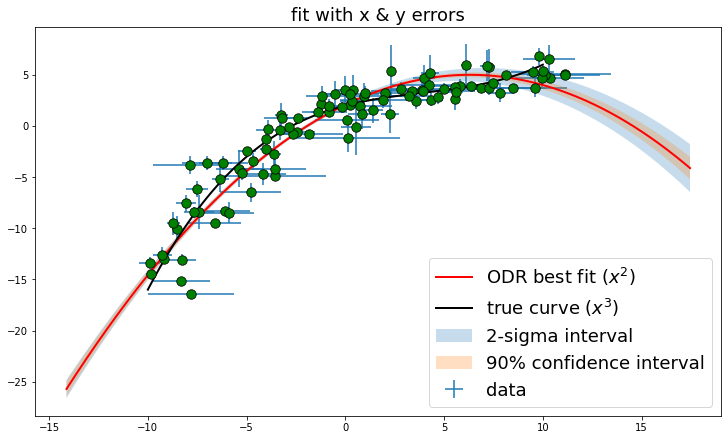

In [397]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), constrained_layout=True)
plt.errorbar(x,y,xerr=noise_x,yerr=noise_y, ls="none",zorder=1, label="data")
sns.scatterplot(x=x,y=y, s=90, color="g", edgecolor="k",zorder=10)
plt.title("fit with x & y errors", fontsize=18)
plot(x_fit, fit, color="r", lw=2, label=r"ODR best fit ($x^2$)")
plot(x0, y0, color="k", lw=2, label=r"true curve ($x^3$)")
axes.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label="2-sigma interval")
axes.fill_between(x_fit, y_fit_10, y_fit_90, alpha=.25, label="90% confidence interval")
legend(loc="lower right",fontsize=18)

print("Note how true curve lies outside the 2-sigma interval, around x=-10")

## Straight ANN

Train time: 20.9 seconds
4/4 [==============================] - 0s 2ms/step - loss: 2.9580

 evaluate 2.957998752593994 

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_51 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_194 (Dense)            (None, 10)                20        
_________________________________________________________________
dense_195 (Dense)            (None, 8)                 88        
_________________________________________________________________
dense_196 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 5         
Total params: 152
Trainable params: 149
Non-trainable params: 3
_________________________________________________________________

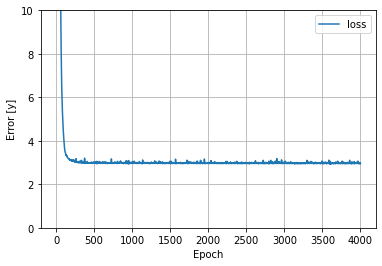

In [400]:
normalizer = make_normalizer(x,y)

# simple NN regresion
model = tf.keras.Sequential([
          normalizer,
          tf.keras.layers.Dense(10,activation="relu"),
          tf.keras.layers.Dense(8,activation="relu"),
          tf.keras.layers.Dense(4,activation="relu"),
          tf.keras.layers.Dense(1)
          ])
  
# Do inference.
start=time.time()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")
history=model.fit(x, y, epochs=4000, verbose=False)
print("Train time: {:.1f} seconds".format(time.time()-start)); 
print("\n evaluate",model.evaluate(x,y),"\n")

y_fit = np.squeeze(model.predict(x_fit))

#plt.figure(figsize=(16, 5))
#sns.scatterplot(x=x_test,y=y_fit, color="r")

model.summary()
#print("model.layers[0].get_weights():\n {} \n".format( model.layers[0].get_weights()))
#model.layers[0].weights
plot_loss(history)

In [151]:
a1=model.predict(x_fit)
#a2=model.predict(x_fit).samples(10)
a3=model(x_fit)

print(a1.shape, a3.shape)
print(type(a1), type(a3))
#dir(model)
#assert isinstance(a3, tfd.Distribution)
#assert isinstance(a1, tfd.Distribution)
#a3.sample(3)
#print(a3)
print("\n model(x) returns a tf.tensor, model.predict(x) returns np.array, same contents\n")

(100, 1) (100, 1)
<class 'numpy.ndarray'> <class 'tensorflow.python.framework.ops.EagerTensor'>

 model(x) returns a tf.tensor, model.predict(x) returns np.array, same contents



In [401]:
y_fit_mean, y_fit_10, y_fit_90 = model_to_statistical_model(model, x_fit, 10, nepochs=2000)

ANN: will do ensemble of NN to find statistics through BMA


ANN models:  10%|█         | 1/10 [00:09<01:25,  9.52s/it]

ANN models:  20%|██        | 2/10 [00:19<01:20, 10.03s/it]

ANN models:  30%|███       | 3/10 [00:29<01:08,  9.82s/it]

ANN models:  40%|████      | 4/10 [00:38<00:58,  9.70s/it]

ANN models:  50%|█████     | 5/10 [00:48<00:48,  9.64s/it]

ANN models:  60%|██████    | 6/10 [00:58<00:38,  9.68s/it]

ANN models:  70%|███████   | 7/10 [01:07<00:28,  9.66s/it]

ANN models:  80%|████████  | 8/10 [01:17<00:19,  9.67s/it]

ANN models:  90%|█████████ | 9/10 [01:27<00:09,  9.73s/it]

ANN models: 100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


 ANN has no error bars, it is just a fit, so we do BMA to get range.



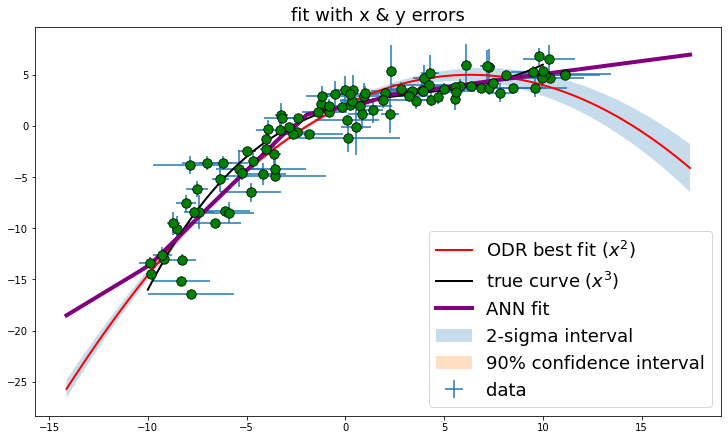

In [402]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), constrained_layout=True)
plt.errorbar(x,y,xerr=noise_x,yerr=noise_y, ls="none",zorder=1, label="data")
sns.scatterplot(x=x,y=y, s=90, color="g", edgecolor="k",zorder=10)
plt.title("fit with x & y errors", fontsize=18)
plot(x_fit, fit, color="r", lw=2, label=r"ODR best fit ($x^2$)")
plot(x0, y0, color="k", lw=2, label=r"true curve ($x^3$)")
plot(x_fit, y_fit_mean, color="purple", lw=4, label="ANN fit")
axes.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label="2-sigma interval")
axes.fill_between(x_fit, y_fit_10, y_fit_90, alpha=.25, label="90% confidence interval")

# get rid of multple entries in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend(by_label.values(), by_label.keys(), loc="lower right",fontsize=18)

print("\n ANN has no error bars, it is just a fit, so we do BMA to get range.\n")

In [380]:
def make_normalizer(x,y) :
  dataset = pd.DataFrame({"x":x, "y":y})
  train_dataset = dataset.sample(frac=0.8, random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
  nx = np.array(dataset['x'])
  normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
  normalizer.adapt(nx)
  return normalizer

def model_to_statistical_model(model, x_to_fit, n, verbose=False, nepochs=500) :
  type = "unknown"
  try :
    if verbose: print("try beta.out")
    # first, we work the fit from Micropore
    beta=model.beta
    type = "odr"
  except:
      try:
        if verbose: print("try model(x_to_fit).samples()")
        model(x_to_fit).sample(10)
        type = "pNN"
      except:
        try:
          if verbose: print("try model(x_to_fit)")
          model(x_to_fit)
          type = "NN"
        except:
          pass
  
  if type == "odr":
    beta_std = out.sd_beta
    order = len(beta)
    print("ODR: assume the model is a polynomial in order of high to low")
    samples = []
    for sample in range(n) :
      y_fit = np.zeros(x_to_fit.size)
      for i,j in zip(range(order)[::-1], range(order)) :
        #print(j, i, beta[j])
        y_fit += np.random.normal(beta[j], beta_std[j]) * x_to_fit**(i)
      samples.append(y_fit)
    y_fit = np.transpose(np.vstack(samples))
    y_fit_mean = y_fit.mean(axis=1)
    y_fit_10 = np.quantile(y_fit, 0.1, axis=1)
    y_fit_90 = np.quantile(y_fit, 0.9, axis=1)
    return y_fit_mean, y_fit_10, y_fit_90

  if type == "NN":  
    print("ANN: will do ensemble of NN to find statistics through BMA")
    # we think this is a ANN, and we can build an ensemble
    samples = []
    for sample in trange(n, desc="ANN models") :
      model.fit(x, y, epochs=nepochs, verbose=False)
      y_fit = model.predict(x_to_fit)
      samples.append(y_fit)
      print("")
    if verbose: print("len samples:",len(samples), "sample:",samples[0].shape)
    y_fit = np.hstack(samples)
    if verbose: print(y_fit.shape)
    y_fit_mean = y_fit.mean(axis=1)
    y_fit_10 = np.quantile(y_fit, 0.1, axis=1)
    y_fit_90 = np.quantile(y_fit, 0.9, axis=1)
    return y_fit_mean, y_fit_10, y_fit_90

  if type == "pNN":  
    print("pNN: use sample")
    samples = model(x_to_fit).sample(n)
    if verbose: print("len samples:",len(samples), "sample:",samples[0].shape)
    y_fit = np.hstack(samples)
    if verbose: print("y_fit: ",y_fit.shape)
    y_fit_mean = y_fit.mean(axis=1)
    if verbose: print("y_fit_mean axis=1: ",y_fit_mean.shape)
    y_fit_10 = np.quantile(y_fit, 0.1, axis=1)
    y_fit_90 = np.quantile(y_fit, 0.9, axis=1)
    return y_fit_mean, y_fit_10, y_fit_90



## pANN Aleroteric errors

In [403]:
normalizer = make_normalizer(x,y)

# Build model.
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(8,activation="relu"),
  tf.keras.layers.Dense(4,activation="relu"),
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
start=time.time()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
model.fit(x,y, epochs=2000, verbose=False);
print("Train time: {:.1f} seconds".format(time.time()-start)); print(model.evaluate(x,y))
print("\nevaluate:",model.evaluate(x,y),"\n")

#[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x)
assert isinstance(yhat, tfd.Distribution)

Train time: 21.1 seconds
4/4 [==============================] - 0s 4ms/step - loss: 1.7703
1.7703001499176025
4/4 [==============================] - 0s 3ms/step - loss: 1.7703

evaluate: 1.7703001499176025 



In [198]:

yhat = model(x)
assert isinstance(yhat, tfd.Distribution)

print("type(x): ",type(x))
print("type(x_fit): ",type(x_fit))
assert isinstance(model(x), tfd.Distribution)
assert isinstance(model(x_fit), tfd.Distribution)
print("model      ",type(model(x_fit)))
print("prediction ",type(model(x)))
print("====")

a1=model.predict(x_fit)
#a2=model(x_fit).samples(10)
a3=model(x_fit)

#print(a1.shape, a2.shape)
print(a1.shape, a3.shape)
#print(type(a1), type(a2))
print(type(a1), type(a3))
assert isinstance(a3, tfd.Distribution)
#assert isinstance(a1, tfd.Distribution)
#a3.sample(3)
#print(a3)
print("\n model(x) returns a tf.tensor, model.predict(x) returns np.array, same contents\n")
dir(model(x))
print(model(x).mean().shape)
print(model(x).sample(3).shape)


type(x):  <class 'numpy.ndarray'>
type(x_fit):  <class 'numpy.ndarray'>
model       <class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'>
prediction  <class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'>
====
(100, 1) (100, 1)
<class 'numpy.ndarray'> <class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'>

 model(x) returns a tf.tensor, model.predict(x) returns np.array, same contents

(100, 1)
(3, 100, 1)


In [404]:

y_fit_mean, y_fit_10, y_fit_90 = model_to_statistical_model(model, x_fit, 1000)
y_fit = np.squeeze(model.predict(x_fit))

delta = (y_fit_mean-y_fit)

print(delta.sum(), delta.std())


pNN: use sample
-25.400217 1.973316


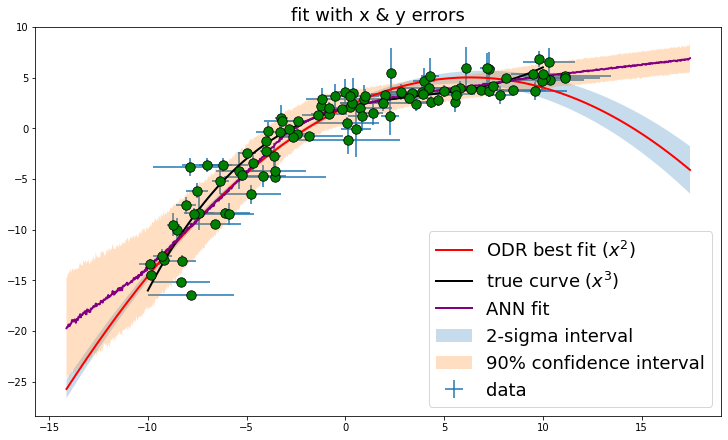

In [408]:
#y_fit_mean, y_fit_10, y_fit_90 = model_to_statistical_model(model, x_fit, 1000)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), constrained_layout=True)
plt.errorbar(x,y,xerr=noise_x,yerr=noise_y, ls="none",zorder=1, label="data")
sns.scatterplot(x=x,y=y, s=90, color="g", edgecolor="k",zorder=10)
plt.title("fit with x & y errors", fontsize=18)
plot(x_fit, fit, color="r", lw=2, label=r"ODR best fit ($x^2$)")
plot(x0, y0, color="k", lw=2, label=r"true curve ($x^3$)")
plot(x_fit, y_fit_mean, color="purple", lw=2, label="ANN fit")
axes.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label="2-sigma interval")
axes.fill_between(x_fit, y_fit_10, y_fit_90, alpha=.25, label="90% confidence interval")

# get rid of multple entries in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend(by_label.values(), by_label.keys(), loc="lower right",fontsize=18)

## pBNN: Epistemic and  Aleroteric errors

In [294]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

  # Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])
  

In [407]:
normalizer = make_normalizer(x,y)

# Build model.
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(8,activation="relu"),
  tf.keras.layers.Dense(4,activation="relu"),
  tfp.layers.DenseVariational(2, 
                  posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                  scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
start=time.time()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
history=model.fit(x,y, epochs=5000, verbose=False);
print("Train time: {:.1f} seconds".format(time.time()-start)); print(model.evaluate(x,y))
print("\nevaluate:",model.evaluate(x,y),"\n")

#[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x)
assert isinstance(yhat, tfd.Distribution)
plot_loss(history, ymax=20)

Train time: 28.5 seconds
4/4 [==============================] - 0s 3ms/step - loss: 1.8360
1.836034893989563
4/4 [==============================] - 0s 3ms/step - loss: 1.8293

evaluate: 1.829330563545227 



TypeError: ignored

pNN: use sample


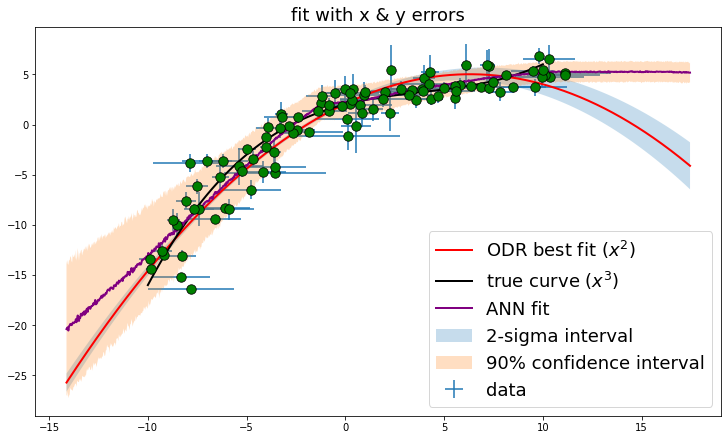

In [409]:
y_fit_mean, y_fit_10, y_fit_90 = model_to_statistical_model(model, x_fit, 1000)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), constrained_layout=True)
plt.errorbar(x,y,xerr=noise_x,yerr=noise_y, ls="none",zorder=1, label="data")
sns.scatterplot(x=x,y=y, s=90, color="g", edgecolor="k",zorder=10)
plt.title("fit with x & y errors", fontsize=18)
plot(x_fit, fit, color="r", lw=2, label=r"ODR best fit ($x^2$)")
plot(x0, y0, color="k", lw=2, label=r"true curve ($x^3$)")
plot(x_fit, y_fit_mean, color="purple", lw=2, label="ANN fit")
axes.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label="2-sigma interval")
axes.fill_between(x_fit, y_fit_10, y_fit_90, alpha=.25, label="90% confidence interval")

# get rid of multple entries in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend(by_label.values(), by_label.keys(), loc="lower right",fontsize=18)

In [415]:
x_fit = np.linspace(min(x)-0.2*(max(x)-min(x)), max(x)+ 0.3*(max(x)-min(x)), 1000)
ym = model.predict(x_fit)
#reload( odr )

def xxfunc(p, x):
  a, b, c = p
  return a * x**2 + b*x + c
def jack2(p, x):
  a, b, c, d, e = p
  return a*x**4 + b*x**3 + c*x**2 +d*x**1 +e

# Model object
xquad_model = odr.Model(jack2)
# Create a RealData object
xdata = odr.RealData(x_fit, ym)#, sx=noise_x, sy=noise_y)

# Set up ODR with the model and data.
xodr = odr.ODR(data, xquad_model, beta0=[0., 1., 1., 1.,1.])

# Run the regression.
xout = xodr.run()

#print fit parameters and 1-sigma estimates
xpopt = xout.beta
xperr = xout.sd_beta
print(xpopt)

xparams =  ["a*x**2", "b*x",  "c"]
xparams =  ["a*x**4", "a*x**3", "b*x**2",  "c*x", "d"]

print("fit parameter 1-sigma errros")
for i in range(len(xpopt)):
  print("{:10s}: {:7.4f} +- {:6.4f}".format(xparams[i], xpopt[i], xperr[i]))


xparams =  ["a*x**2", "b*x",  "c"]
dfit=[-0.07, 0.51, 2.05]; dfit_err=[0.002,0.012,0.064]
print("\n == orig")
for i in range(len(xpopt)):
  print("{:10s}: {:7.4f} +- {:6.4f}".format(xparams[i],dfit[i],dfit_err[i]))



[-6.82419686e-07  5.39524524e-03 -7.15219689e-02  5.25093334e-01
  2.03969630e+00]
fit parameter 1-sigma errros
a*x**4    : -0.0000 +- 0.0001
a*x**3    :  0.0054 +- 0.0004
b*x**2    : -0.0715 +- 0.0064
c*x       :  0.5251 +- 0.0296
d         :  2.0397 +- 0.0623

 == orig
a*x**2    : -0.0700 +- 0.0020
b*x       :  0.5100 +- 0.0120
c         :  2.0500 +- 0.0640


IndexError: ignored

## Supporting code

In [314]:
def plot_loss(history, ymax=10):
  plt.plot(history.history['loss'], label='loss')
  #plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)


In [108]:
def make_posterior_predictive_distribution (sigma, verbose=False) :
    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    range_x = np.arange(14.0,15.0,0.05) ; 
    if verbose : print("range_x: ", range_x.shape)
    range_y = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(20000), 
        elems=tf.constant(range_x , dtype=dtype )  )
    range_y = tf.squeeze(range_y)
    if verbose: print("range_y  ", range_y.shape)

    range_mean = tf.math.reduce_mean(range_y, axis=1).numpy()
    range_std = tf.math.reduce_std(range_y, axis=1).numpy()
    range_90l = range_mean - 2*range_std
    range_90u = range_mean + 2*range_std
    df = pd.DataFrame({"mean": range_mean})
    df["range"]= range_x
    df["std"]= range_std
    df["90l"]= range_90l
    df["90u"]= range_90u
    return df

# for wide spread use
# ppd_df is the output of make_posterior_predictive_distribution
def yp_on_yt_plot (y_predictions, y_sigma, y_test, ppd_df) :
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), constrained_layout=True)

    ax[0].errorbar( x=np.array(y_test), y=y_predictions, yerr=y_sigma,fmt='o',
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals')
    sns.regplot(x=np.array(y_test), y=y_predictions,
        scatter=False, line_kws=dict(alpha=0.5), fit_reg=True, label="linear regression", 
        truncate=False, ax=ax[0])
    ax[0].plot(ppd_df["range"],ppd_df["mean"], color="black", label="y=x, 90% posterior predictive")
    ax[0].fill_between(ppd_df["range"], ppd_df["90l"], ppd_df["90u"], color='k', alpha=.1)
    ax[0].set(title='Model Predictions for Test Sample', xlabel='y',ylabel='y_pred');
    ax[0].legend(loc='lower right')
         
    ax[1].errorbar( x=np.array(y_test), y=y_predictions-np.array(y_test), yerr=y_sigma,fmt='o', 
        #ecolor=sns_c[1], mfc=sns_c[4],
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals',)
    sns.regplot(x=np.array(y_test), y = y_predictions-np.array(y_test),
        scatter=False, line_kws=dict(alpha=0.5),  fit_reg=True, label="linear regression",  
        truncate=False,  ax=ax[1])
    ax[1].plot(ppd_df["range"],np.zeros(ppd_df["mean"].size), 
               color="black", label="y=x, 90% posterior predictive")
    ax[1].fill_between(ppd_df["range"], ppd_df["90l"]-ppd_df["mean"], ppd_df["90u"]-ppd_df["mean"], color='k', alpha=.1)
    ax[1].set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
    ax[1].legend(loc='lower right')

In [ ]:
yhat  = tf.transpose(tf.squeeze(model(x_fit).sample(100)))
posterior_mean = tf.math.reduce_mean(yhat,axis=1).numpy()
posterior_std = tf.math.reduce_std(yhat,axis=1).numpy()
print ("yhat", yhat.shape)
print ("posterior_mean", posterior_mean.shape)

chisq = (((posterior_mean-y)/posterior_std)**2).sum()/(y.size)
rms = np.sqrt(((posterior_mean-y)**2).sum()/y.size)

print("\nTest data")
print ("posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

# posterior predictive distribution 
ppd_df = make_posterior_predictive_distribution (posterior_std.mean())